# Example how to store the events from algorithms in the dataclass per recording file

In [40]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt

from ngmt.modules import GSDB, ICDA
# from ngmt.utils.importers import import_hasomed_imu
from ngmt.datasets import mobilised
from ngmt.utils.ngmt_data_classes import EventData

from ngmt.config import cfg_colors

First we load the data and put the in the desired dataclasses.

In [41]:
# set path
# path_example = r"C:\Users\User\Desktop\kiel\NGMT\examples\data\exDataHasomed.csv"
path_example = "/home/robbin/Datasets/Mobilise-D/rawdata/sub-1008/Free-living/data.mat"

# load data via the hasomed importer and returns a RecordingData object
# data = import_hasomed_imu(path_example)
motion_data = mobilised.load_file(file_path=path_example)
print(recording_data)

MotionData(data=[RecordingData(name='Mobilise-D_TVS', data=array([[ 5.70834318e-01, -1.26878311e-01, -3.05712361e-01, ...,
        -3.57099772e+00,  6.71993664e-01,  9.97682600e+02],
       [ 5.46620458e-01, -1.33736505e-01, -3.23710673e-01, ...,
        -3.58299679e+00,  6.96993312e-01,  9.97683400e+02],
       [ 5.35645320e-01, -1.25755139e-01, -3.62685592e-01, ...,
        -3.59899549e+00,  7.21992960e-01,  9.97684300e+02],
       ...,
       [ 7.06245474e-02, -8.82652807e-03,  9.76881774e-01, ...,
        -5.18099761e+00, -4.14000096e+00,  9.98279000e+02],
       [ 7.20590617e-02, -1.15567246e-02,  9.75199782e-01, ...,
        -5.17599814e+00, -4.14200232e+00,  9.98278300e+02],
       [ 7.06186469e-02, -9.84600206e-03,  9.77181607e-01, ...,
        -5.17199865e+00, -4.14700225e+00,  9.98277600e+02]]), sampling_frequency=100.0, times=array([1.60224031e+09, 1.60224031e+09, 1.60224031e+09, ...,
       1.60224954e+09, 1.60224954e+09, 1.60224954e+09]), channels=ChannelData(name=['LowerB

In [42]:
for i in range(len(motion_data.data)):
    print(f"{i+1:d}: {motion_data.data[i].name}, shape: {motion_data.data[i].data.shape}, \n\tchannels: {motion_data.data[i].channels.name}")

1: Mobilise-D_TVS, shape: (923201, 10), 
	channels: ['LowerBack_ACCEL_x', 'LowerBack_ACCEL_y', 'LowerBack_ACCEL_z', 'LowerBack_GYRO_x', 'LowerBack_GYRO_y', 'LowerBack_GYRO_z', 'LowerBack_MAGN_x', 'LowerBack_MAGN_y', 'LowerBack_MAGN_z', 'LowerBack_BARO_n/a']


In [43]:
# select only data channels of type accceleration (ACCEL)
type_oi = "ACCEL"
acc = motion_data.data[0].pick_channel_types(type_oi)  # index 0 corresponds to the LowerBack
fs = motion_data.data[0].sampling_frequency
print(f"Sampling frequency: {fs} Hz")

Sampling frequency: 100.0 Hz


In [44]:
acc.data.shape

(923201, 3)

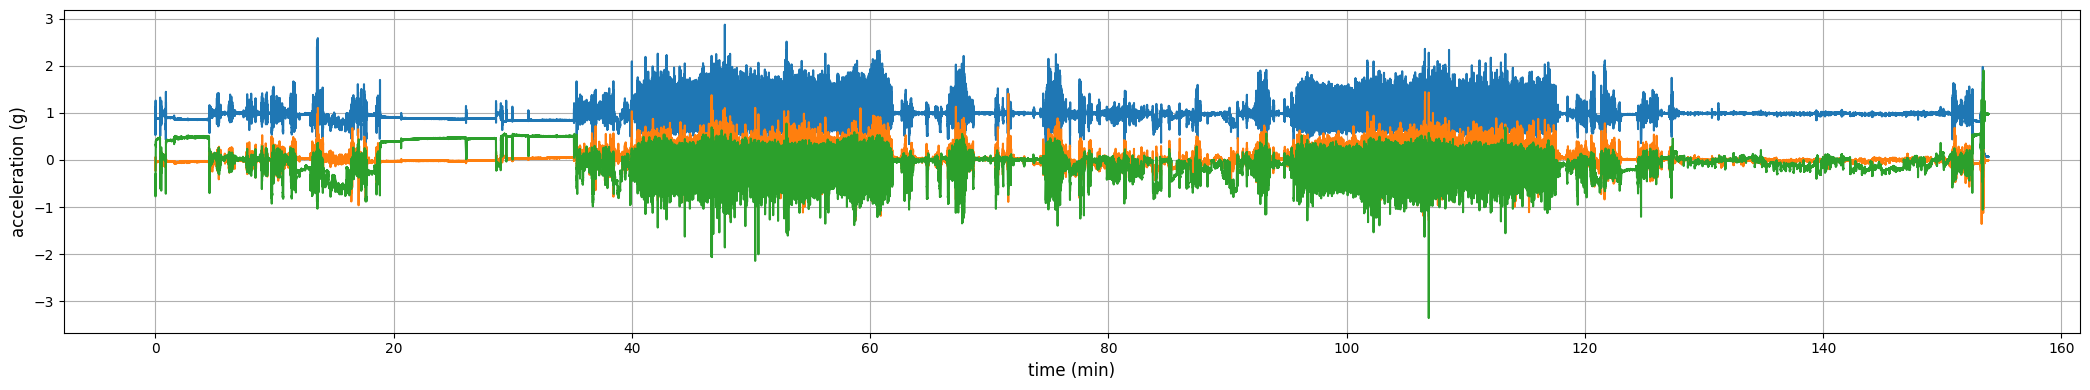

In [45]:
fig, ax = plt.subplots(figsize=(21, 4))
ax.plot(np.arange(acc.data.shape[0])/fs/60, acc.data)
ax.grid()
ax.set_ylabel(f"acceleration (g)", fontsize=12)
ax.set_xlabel(f"time (min)", fontsize=12)
plt.tight_layout()
plt.show()

Select the appropriate part of the data for the GSD algorithm.

In [46]:
acc_data_lower_back = acc.data

# Use Gait_Sequence_Detection to detect gait sequence
gait_sequences = GSDB.Gait_Sequence_Detection(
    imu_acceleration=acc_data_lower_back,
    sampling_frequency=fs,
    plot_results=False,
)

Gait sequence(s) detected.


In [47]:
gait_sequences

[{'Start': 694.0, 'End': 701.275, 'fs': 100.0},
 {'Start': 817.8, 'End': 821.8, 'fs': 100.0},
 {'Start': 2427.575, 'End': 3705.25, 'fs': 100.0},
 {'Start': 4027.925, 'End': 4082.825, 'fs': 100.0},
 {'Start': 4488.5, 'End': 4563.125, 'fs': 100.0},
 {'Start': 5563.325, 'End': 5598.8, 'fs': 100.0},
 {'Start': 5746.575, 'End': 5761.775, 'fs': 100.0},
 {'Start': 5765.65, 'End': 5787.325, 'fs': 100.0},
 {'Start': 5794.1, 'End': 6106.775, 'fs': 100.0},
 {'Start': 6110.05, 'End': 7037.025, 'fs': 100.0}]

The events are put into a pandas DataFrame, and follow the conventions outlined in the BIDS documentation (i.e. https://bids-specification.readthedocs.io/en/stable/modality-specific-files/task-events.html).

In [48]:
import pandas as pd

my_events = {
    "onset": [
        int(gs["Start"] * fs) for gs in gait_sequences
    ],
    "duration": [
        int((gs["End"] - gs["Start"]) * fs) for gs in gait_sequences
    ],
    "event_type": [
        "gait_sequence" for gs in gait_sequences
    ]
}

my_events_df = pd.DataFrame(my_events)
my_events_df

,onset,duration,event_type
0,69400,727,gait_sequence
1,81780,400,gait_sequence
2,242757,127767,gait_sequence
3,402792,5489,gait_sequence
4,448850,7462,gait_sequence
5,556332,3547,gait_sequence
6,574657,1519,gait_sequence
7,576565,2167,gait_sequence
8,579410,31267,gait_sequence
9,611005,92697,gait_sequence


Detect inital contacts

In [49]:
# Now, use Initial_Contact_Detection to detect initial contacts within detected gait sequences.
initial_contacts = ICDA.Initial_Contact_Detection(
    imu_acceleration=acc_data_lower_back,
    gait_sequences=gait_sequences,
    sampling_frequency=fs,
    plot_results=False,
)

In [50]:
initial_contacts

[{'Start': 694.0,
  'End': 701.275,
  'fs': 100.0,
  'IC': [694.275,
   694.725,
   695.275,
   695.8,
   696.3,
   696.95,
   697.45,
   698.05,
   698.625,
   699.2,
   699.75,
   700.275,
   700.875],
  'SamplingFrequency': 100.0},
 {'Start': 817.8,
  'End': 821.8,
  'fs': 100.0,
  'IC': [817.9749999999999,
   818.3249999999999,
   818.8499999999999,
   819.375,
   819.9749999999999,
   820.55,
   821.175,
   821.675],
  'SamplingFrequency': 100.0},
 {'Start': 2427.575,
  'End': 3705.25,
  'fs': 100.0,
  'IC': [2428.125,
   2428.6749999999997,
   2429.1499999999996,
   2429.625,
   2430.1749999999997,
   2430.7,
   2431.25,
   2431.7999999999997,
   2432.325,
   2432.85,
   2433.35,
   2433.8999999999996,
   2434.4249999999997,
   2434.9249999999997,
   2435.4249999999997,
   2436.0,
   2436.5249999999996,
   2437.075,
   2437.6,
   2438.125,
   2438.6749999999997,
   2439.2,
   2439.7749999999996,
   2440.2999999999997,
   2440.825,
   2441.45,
   2441.975,
   2442.5499999999997,
 

In [51]:
# Add the initial contacts to the existing events
for gs in initial_contacts:
    my_events["onset"] += [int(ic * fs) for ic in gs["IC"]]
    my_events["duration"] += [0 for ic in gs["IC"]]
    my_events["event_type"] += ["initial_contact" for ic in gs["IC"]]

my_events_df = pd.DataFrame(my_events)
my_events_df

,onset,duration,event_type
0,69400,727,gait_sequence
1,81780,400,gait_sequence
2,242757,127767,gait_sequence
3,402792,5489,gait_sequence
4,448850,7462,gait_sequence
...,...,...,...
5164,703462,0,initial_contact
5165,703515,0,initial_contact
5166,703567,0,initial_contact
5167,703620,0,initial_contact


In [53]:
my_events_df.sort_values(by="onset", axis=0, ascending=True, inplace=True)
my_events_df.head()

,onset,duration,event_type
0,69400,727,gait_sequence
10,69427,0,initial_contact
11,69472,0,initial_contact
12,69527,0,initial_contact
13,69580,0,initial_contact


Plot the data and GSD events and ICD events in different colors.

In [54]:
binary_vector = np.zeros((acc_data_lower_back.shape[0],))
print(f"{binary_vector.shape}")

(923201,)


In [56]:
for _, gs in my_events_df[(my_events_df["event_type"]=="gait_sequence")].iterrows():
    binary_vector[gs["onset"]:gs["onset"]+gs["duration"]] = 1

In [60]:
np.arange(len(acc_data_lower_back))

array([     0,      1,      2, ..., 923198, 923199, 923200])

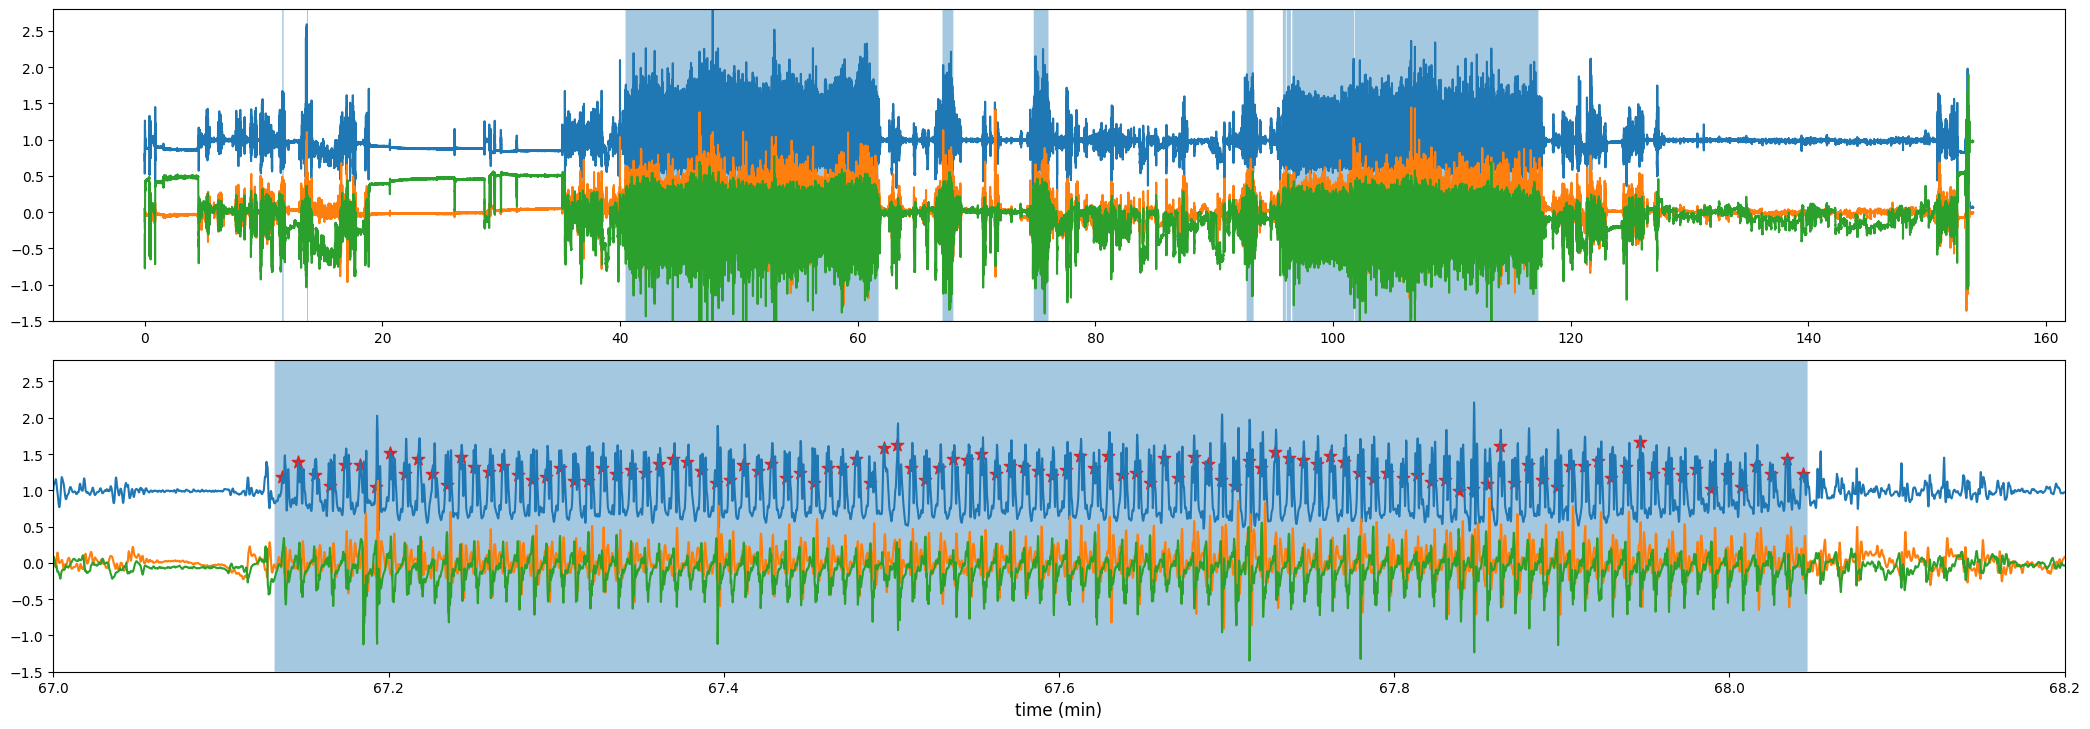

In [77]:
fig, axs = plt.subplots(2, 1, sharex=False, sharey=True, figsize=(21, 7.4))
axs[0].fill_between(np.arange(len(acc_data_lower_back))/fs/60, 0, 1, where=binary_vector, alpha=0.4, transform=axs[0].get_xaxis_transform())
axs[0].plot(np.arange(len(acc_data_lower_back))/fs/60, acc_data_lower_back)
axs[1].fill_between(np.arange(len(acc_data_lower_back))/fs/60, 0, 1, where=binary_vector, alpha=0.4, transform=axs[1].get_xaxis_transform())
axs[1].plot(np.arange(len(acc_data_lower_back))/fs/60, acc_data_lower_back)
axs[1].scatter(my_events_df[(my_events_df["event_type"]=="initial_contact")]["onset"].to_numpy()/fs/60, 
               acc_data_lower_back[my_events_df[(my_events_df["event_type"]=="initial_contact")]["onset"].to_numpy(),0],
               marker="*", color="tab:red", s=88)
axs[1].set_xlim((67, 68.2))
axs[1].set_ylim((-1.5, 2.8))
axs[1].set_xlabel(f"time (min)", fontsize=12)
plt.tight_layout()
plt.show()